In [29]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import kerastuner as kt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split

<ipython-input-29-6c7767d0e42a>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


## Lectura de los datos

In [12]:
items_onehot_encoded_df = pd.read_csv('../../Data/items_onehot_encoded.csv')
items_onehot_encoded_df

,item_id,1_60,1_143,1_358,1_461,1_517,1_771,2_53,2_56,2_83,...,72_665,72_671,72_712,72_747,72_748,72_751,72_829,72_883,73_91,73_544
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,28139,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
23687,28140,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
23688,28141,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
23689,28142,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Preprocesamiento de los datos

In [13]:
X = items_onehot_encoded_df.drop('item_id', axis=1).to_numpy()
X.shape

(23691, 904)

In [14]:
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [15]:
X_train.shape

(21321, 904)

In [16]:
X_test.shape

(2370, 904)

# Autoencoder

## Codificacion encoder

In [17]:
input_shape = X.shape[1] # 904
intermediate_dim_1 = 128
intermediate_dim_2 = 64
intermediate_dim_3 = 32
intermediate_dim_4 = 16
latent_dim = 8

In [18]:
# Define encoder model
inputs = Input(shape=input_shape,name='encoder_input')
x = Activation('relu')(inputs)
x = Dense(intermediate_dim_1, name='hidden_layer_1_e')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_2, name='hidden_layer_2_e')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_3, name='hidden_layer_3_e')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_4, name='hidden_layer_4_e')(x)
x = Activation('relu')(x)
outputs = Dense(latent_dim, name='latent_space')(x)
#outputs = LayerNormalization(axis=1)(x)

encoder = Model(inputs=inputs, outputs=outputs, name='dense_encoder')
encoder.summary()

Model: "dense_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 904)]             0         
_________________________________________________________________
activation_11 (Activation)   (None, 904)               0         
_________________________________________________________________
hidden_layer_1_e (Dense)     (None, 128)               115840    
_________________________________________________________________
activation_12 (Activation)   (None, 128)               0         
_________________________________________________________________
hidden_layer_2_e (Dense)     (None, 64)                8256      
_________________________________________________________________
activation_13 (Activation)   (None, 64)                0         
_________________________________________________________________
hidden_layer_3_e (Dense)     (None, 32)              

## Codificacion decoder

In [19]:
# Define decoder model
latent_input = Input(shape = (latent_dim,), name='decoder_input')
x = Activation('relu')(latent_input)
x = Dense(intermediate_dim_4 , name='hidden_layer_de_4_d')(latent_input)
x = Activation('relu')(x)
x = Dense(intermediate_dim_3 , name='hidden_layer_de_3_d')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_2 , name='hidden_layer_de_2_d')(x)
x = Activation('relu')(x)
x = Dense(intermediate_dim_1 , name='hidden_layer_de_1_d')(x)
x = Activation('relu')(x)
x = Dense(input_shape, name='original_space')(x)
x = Activation('sigmoid')(x)

decoder = Model (inputs=latent_input, outputs=x, name='decoder_dense')

decoder.summary()

Model: "decoder_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 8)]               0         
_________________________________________________________________
hidden_layer_de_4_d (Dense)  (None, 16)                144       
_________________________________________________________________
activation_17 (Activation)   (None, 16)                0         
_________________________________________________________________
hidden_layer_de_3_d (Dense)  (None, 32)                544       
_________________________________________________________________
activation_18 (Activation)   (None, 32)                0         
_________________________________________________________________
hidden_layer_de_2_d (Dense)  (None, 64)                2112      
_________________________________________________________________
activation_19 (Activation)   (None, 64)              

## Auto encoder

In [20]:
# Autoencoder Model
autoencoder = Model(inputs=inputs, 
                    outputs=decoder(encoder(inputs)),
                    name='autoencoder_dnn')

#Summary
autoencoder.summary()

Model: "autoencoder_dnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 904)]             0         
_________________________________________________________________
dense_encoder (Functional)   (None, 8)                 126840    
_________________________________________________________________
decoder_dense (Functional)   (None, 904)               127736    
Total params: 254,576
Trainable params: 254,576
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=3)

In [23]:
optimizer = Adam(learning_rate=1e-3)
loss_fn = MeanSquaredError()
autoencoder.compile(optimizer= optimizer, loss = loss_fn)

In [24]:
epochs = 100
batch_size = 32

history = autoencoder.fit(X_train, X_train, validation_data = (X_test, X_test), epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Epoch 1/100
667/667 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0156
Epoch 2/100
667/667 [==============================] - 1s 2ms/step - loss: 0.0142 - val_loss: 0.0130
Epoch 3/100
667/667 [==============================] - 1s 2ms/step - loss: 0.0126 - val_loss: 0.0123
Epoch 4/100
667/667 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 5/100
667/667 [==============================] - 1s 2ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 6/100
667/667 [==============================] - 1s 2ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 7/100
667/667 [==============================] - 1s 2ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 8/100
667/667 [==============================] - 1s 2ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 9/100
667/667 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 10/100
667/667 [==============================] - 1s 2ms/step - loss: 0.0093 - val_lo

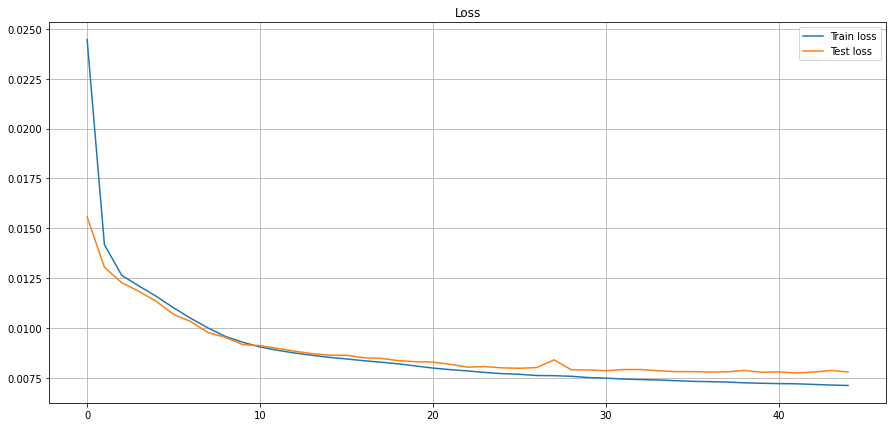

In [28]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Test loss')
plt.title('Loss')
plt.legend()
plt.grid()
plt.show()

# Auto Tuning del la arquitectura

In [44]:
class MyHyperModel(kt.HyperModel):
    
    def build(self, hp):
        
        input_shape = X.shape[1] # 904
    
        hp_intermediate_dim_1 = hp.Int("intermediate_dim_1", min_value = 64, max_value = 1024, step = 64, default=128)
        hp_intermediate_dim_2 = hp.Int("intermediate_dim_2", min_value = 32, max_value = 512, step = 32, default=64)
        hp_intermediate_dim_3 = hp.Int("intermediate_dim_3", min_value = 16, max_value = 256, step = 16, default=32)
        hp_intermediate_dim_4 = hp.Int("intermediate_dim_4", min_value = 8, max_value = 128, step = 8, default=16)
        hp_latent_dim = hp.Int("latent_dim", min_value = 1, max_value = 128, step = 4, default=8)

        hp_activation = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')

        hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5], default=1e-3)


        # Define encoder model
        inputs = Input(shape=input_shape,name='encoder_input')
        x = Activation(hp_activation)(inputs)
        x = Dense(hp_intermediate_dim_1, name='hidden_layer_1_e')(x)
        x = Activation(hp_activation)(x)
        x = Dense(hp_intermediate_dim_2, name='hidden_layer_2_e')(x)
        x = Activation(hp_activation)(x)
        x = Dense(hp_intermediate_dim_3, name='hidden_layer_3_e')(x)
        x = Activation(hp_activation)(x)
        x = Dense(hp_intermediate_dim_4, name='hidden_layer_4_e')(x)
        x = Activation(hp_activation)(x)
        outputs = Dense(hp_latent_dim, name='latent_space')(x)

        encoder = Model(inputs=inputs, outputs=outputs, name='dense_encoder')

        # Define decoder model
        latent_input = Input(shape = (hp_latent_dim,), name='decoder_input')
        x = Activation(hp_activation)(latent_input)
        x = Dense(hp_intermediate_dim_4 , name='hidden_layer_de_4_d')(latent_input)
        x = Activation(hp_activation)(x)
        x = Dense(hp_intermediate_dim_3 , name='hidden_layer_de_3_d')(x)
        x = Activation(hp_activation)(x)
        x = Dense(hp_intermediate_dim_2 , name='hidden_layer_de_2_d')(x)
        x = Activation(hp_activation)(x)
        x = Dense(hp_intermediate_dim_1 , name='hidden_layer_de_1_d')(x)
        x = Activation(hp_activation)(x)
        x = Dense(input_shape, name='original_space')(x)
        x = Activation('sigmoid')(x)

        decoder = Model (inputs=latent_input, outputs=x, name='decoder_dense')


        # Autoencoder Model
        model = Model(inputs=inputs, outputs=decoder(encoder(inputs)), name='autoencoder_dnn')


        optimizer = Adam(learning_rate=hp_learning_rate)
        loss_fn = MeanSquaredError()
        model.compile(optimizer= optimizer, loss = loss_fn)
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128, 256], default = 32),
            **kwargs,
        )

In [45]:
tuner = kt.Hyperband(
    MyHyperModel(),
    objective = kt.Objective("val_loss", direction="min"),
    max_epochs = 128,
    factor = 3,
    directory = "tuner_autoencoder_dnn",
    project_name = "autoencoder_dnn"
)

In [46]:
tuner.search(
    X_train,X_train,
    epochs = 128, 
    validation_data = (X_test, X_test)
)

Trial 254 Complete [00h 08m 25s]
val_loss: 0.0073876893147826195

Best val_loss So Far: 0.0018135642167180777
Total elapsed time: 02h 09m 02s
INFO:tensorflow:Oracle triggered exit


In [47]:
best_hps = tuner.get_best_hyperparameters(num_trials =1)[0]

In [55]:
print('intermediate_dim_1: ' + str(best_hps.get("intermediate_dim_1")))
print('intermediate_dim_2: ' + str(best_hps.get("intermediate_dim_2")))
print('intermediate_dim_3: ' + str(best_hps.get("intermediate_dim_3")))
print('intermediate_dim_4: ' + str(best_hps.get("intermediate_dim_4")))
print('latent_dim: ' + str(best_hps.get("latent_dim")))

print('dense_activation: ' + str(best_hps.get("dense_activation")))
print('learning_rate: ' + str(best_hps.get("learning_rate")))

print('batch_size: ' + str(best_hps.get("batch_size")))

intermediate_dim_1: 1024
intermediate_dim_2: 224
intermediate_dim_3: 160
intermediate_dim_4: 96
latent_dim: 101
dense_activation: tanh
learning_rate: 0.001
batch_size: 128


# Autoencoder tuneado

In [73]:
input_shape = X.shape[1] # 904
intermediate_dim_1 = best_hps.get("intermediate_dim_1")
intermediate_dim_2 = best_hps.get("intermediate_dim_2")
intermediate_dim_3 = best_hps.get("intermediate_dim_3")
intermediate_dim_4 = best_hps.get("intermediate_dim_4")
latent_dim = best_hps.get("latent_dim")

In [74]:
# Define encoder model
inputs = Input(shape=input_shape,name='encoder_input')
x = Activation('tanh')(inputs)
x = Dense(intermediate_dim_1, name='hidden_layer_1_e')(x)
x = Activation('tanh')(x)
x = Dense(intermediate_dim_2, name='hidden_layer_2_e')(x)
x = Activation('tanh')(x)
x = Dense(intermediate_dim_3, name='hidden_layer_3_e')(x)
x = Activation('tanh')(x)
x = Dense(intermediate_dim_4, name='hidden_layer_4_e')(x)
x = Activation('tanh')(x)
outputs = Dense(latent_dim, name='latent_space')(x)
#outputs = LayerNormalization(axis=1)(x)

encoder = Model(inputs=inputs, outputs=outputs, name='dense_encoder')
encoder.summary()

Model: "dense_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 904)]             0         
_________________________________________________________________
activation_49 (Activation)   (None, 904)               0         
_________________________________________________________________
hidden_layer_1_e (Dense)     (None, 1024)              926720    
_________________________________________________________________
activation_50 (Activation)   (None, 1024)              0         
_________________________________________________________________
hidden_layer_2_e (Dense)     (None, 224)               229600    
_________________________________________________________________
activation_51 (Activation)   (None, 224)               0         
_________________________________________________________________
hidden_layer_3_e (Dense)     (None, 160)             

In [75]:
# Define decoder model
latent_input = Input(shape = (latent_dim,), name='decoder_input')
x = Activation('tanh')(latent_input)
x = Dense(intermediate_dim_4 , name='hidden_layer_de_4_d')(latent_input)
x = Activation('tanh')(x)
x = Dense(intermediate_dim_3 , name='hidden_layer_de_3_d')(x)
x = Activation('tanh')(x)
x = Dense(intermediate_dim_2 , name='hidden_layer_de_2_d')(x)
x = Activation('tanh')(x)
x = Dense(intermediate_dim_1 , name='hidden_layer_de_1_d')(x)
x = Activation('tanh')(x)
x = Dense(input_shape, name='original_space')(x)
x = Activation('sigmoid')(x)

decoder = Model (inputs=latent_input, outputs=x, name='decoder_dense')

decoder.summary()

Model: "decoder_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 101)]             0         
_________________________________________________________________
hidden_layer_de_4_d (Dense)  (None, 96)                9792      
_________________________________________________________________
activation_55 (Activation)   (None, 96)                0         
_________________________________________________________________
hidden_layer_de_3_d (Dense)  (None, 160)               15520     
_________________________________________________________________
activation_56 (Activation)   (None, 160)               0         
_________________________________________________________________
hidden_layer_de_2_d (Dense)  (None, 224)               36064     
_________________________________________________________________
activation_57 (Activation)   (None, 224)             

In [76]:
# Autoencoder Model
autoencoder = Model(inputs=inputs, 
                    outputs=decoder(encoder(inputs)),
                    name='autoencoder_dnn')

#Summary
autoencoder.summary()

Model: "autoencoder_dnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 904)]             0         
_________________________________________________________________
dense_encoder (Functional)   (None, 101)               1217573   
_________________________________________________________________
decoder_dense (Functional)   (None, 904)               1218376   
Total params: 2,435,949
Trainable params: 2,435,949
Non-trainable params: 0
_________________________________________________________________


In [77]:
optimizer = Adam(learning_rate=0.001)
loss_fn = MeanSquaredError()
autoencoder.compile(optimizer= optimizer, loss = loss_fn)

In [78]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=3)

In [79]:
epochs = 128
batch_size = 128

history = autoencoder.fit(X, X, epochs = epochs, batch_size=batch_size, callbacks=[callback], verbose=1)

Epoch 1/128
186/186 [==============================] - 2s 10ms/step - loss: 0.0228
Epoch 2/128
186/186 [==============================] - 2s 10ms/step - loss: 0.0175
Epoch 3/128
186/186 [==============================] - 2s 9ms/step - loss: 0.0151
Epoch 4/128
186/186 [==============================] - 2s 9ms/step - loss: 0.0135
Epoch 5/128
186/186 [==============================] - 2s 9ms/step - loss: 0.0123
Epoch 6/128
186/186 [==============================] - 2s 10ms/step - loss: 0.0111
Epoch 7/128
186/186 [==============================] - 2s 9ms/step - loss: 0.0099
Epoch 8/128
186/186 [==============================] - 2s 10ms/step - loss: 0.0087
Epoch 9/128
186/186 [==============================] - 2s 10ms/step - loss: 0.0079
Epoch 10/128
186/186 [==============================] - 2s 10ms/step - loss: 0.0071
Epoch 11/128
186/186 [==============================] - 2s 10ms/step - loss: 0.0065
Epoch 12/128
186/186 [==============================] - 2s 10ms/step - loss: 0.0060
Epoch

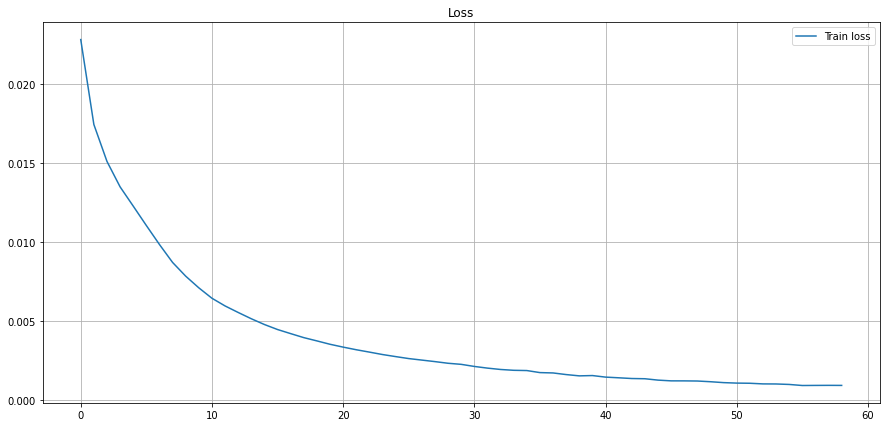

In [80]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'],label='Train loss')
plt.title('Loss')
plt.legend()
plt.grid()
plt.show()

In [101]:
encoder.save('../../Models/encoder_dnn')
decoder.save('../../Models/decoder_dnn')
autoencoder.save('../../Models/autoencoder_dnn')

INFO:tensorflow:Assets written to: ../../Models/encoder_dnn/assets
INFO:tensorflow:Assets written to: ../../Models/decoder_dnn/assets
INFO:tensorflow:Assets written to: ../../Models/autoencoder_dnn/assets


# Codificacion de los items a espacio latente

In [82]:
encoded_items = encoder(X)

In [84]:
encoded_items.shape

TensorShape([23691, 101])

In [91]:
encoded_items_df = pd.DataFrame(encoded_items.numpy())
encoded_items_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,-0.468092,0.309055,0.104904,-0.622374,0.489114,1.038283,-0.267152,0.446968,-0.218285,-0.264846,...,-0.193829,0.539587,0.545378,-0.118356,0.039329,0.552155,0.665650,0.593036,1.099409,0.516310
1,-0.132719,-0.003760,-0.898503,0.003382,-0.646164,-0.368113,-0.458447,1.075983,0.028201,0.125105,...,0.013566,0.566093,0.026199,0.408727,-0.519762,-0.681245,0.979448,0.569439,0.087361,-0.786505
2,-0.470149,-1.041913,0.351812,-0.311612,-0.051899,-0.796536,0.216949,0.750239,-0.078380,-0.566603,...,-0.118376,0.631876,0.114137,0.504360,0.271374,-0.149201,-0.565141,0.377492,0.397151,0.446580
3,-0.089269,0.511752,-0.467416,0.275739,0.524776,1.104646,-0.099435,0.583648,0.304238,0.289184,...,0.398914,0.411674,-0.511062,0.060817,0.434734,-0.724116,0.515993,0.495495,0.563491,0.155011
4,-0.537407,-0.280657,-0.190584,-0.285847,-0.581638,-0.419533,-1.265952,0.948579,0.229027,-0.135409,...,-0.700630,0.138696,-0.762675,0.274068,-0.696598,0.212480,-0.117870,0.004375,0.556120,-0.621206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,-0.611239,-0.102328,0.731304,-0.289264,-0.844854,-0.705494,0.007140,-0.340611,-0.047707,0.441923,...,-0.259639,-0.527089,-0.513785,0.488504,-0.111721,0.484417,-0.212577,0.590068,-0.250478,-1.375468
23687,0.359543,0.418163,-0.098012,-0.410402,0.304354,-0.235069,0.217527,0.994392,0.429139,0.828811,...,-0.125570,0.767878,-0.645546,-0.568457,-1.335643,-0.524085,0.700682,-0.490298,-0.544381,-0.233994
23688,0.471290,-0.229834,-0.052106,0.117669,0.134728,-0.762290,0.039601,0.839275,-0.178341,-0.321437,...,0.458896,0.593677,-0.271718,0.179948,-0.778051,-0.468863,0.373523,0.392187,0.264578,-0.520669
23689,-0.256480,-0.222105,-0.091156,-0.397711,0.126637,0.245787,-0.747502,-0.024197,0.146774,0.168911,...,-0.000106,-0.089100,1.358653,-0.280247,0.311113,-0.304291,1.015457,0.697587,0.576320,0.524419


In [92]:
items_onehot_encoded_df.item_id

0            2
1            3
2            4
3            7
4            8
         ...  
23686    28139
23687    28140
23688    28141
23689    28142
23690    28143
Name: item_id, Length: 23691, dtype: int64

In [95]:
encoded_items_df.insert(loc=0, column='item_id', value=list(items_onehot_encoded_df.item_id))

In [96]:
encoded_items_df

,item_id,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
0,2,-0.468092,0.309055,0.104904,-0.622374,0.489114,1.038283,-0.267152,0.446968,-0.218285,...,-0.193829,0.539587,0.545378,-0.118356,0.039329,0.552155,0.665650,0.593036,1.099409,0.516310
1,3,-0.132719,-0.003760,-0.898503,0.003382,-0.646164,-0.368113,-0.458447,1.075983,0.028201,...,0.013566,0.566093,0.026199,0.408727,-0.519762,-0.681245,0.979448,0.569439,0.087361,-0.786505
2,4,-0.470149,-1.041913,0.351812,-0.311612,-0.051899,-0.796536,0.216949,0.750239,-0.078380,...,-0.118376,0.631876,0.114137,0.504360,0.271374,-0.149201,-0.565141,0.377492,0.397151,0.446580
3,7,-0.089269,0.511752,-0.467416,0.275739,0.524776,1.104646,-0.099435,0.583648,0.304238,...,0.398914,0.411674,-0.511062,0.060817,0.434734,-0.724116,0.515993,0.495495,0.563491,0.155011
4,8,-0.537407,-0.280657,-0.190584,-0.285847,-0.581638,-0.419533,-1.265952,0.948579,0.229027,...,-0.700630,0.138696,-0.762675,0.274068,-0.696598,0.212480,-0.117870,0.004375,0.556120,-0.621206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,28139,-0.611239,-0.102328,0.731304,-0.289264,-0.844854,-0.705494,0.007140,-0.340611,-0.047707,...,-0.259639,-0.527089,-0.513785,0.488504,-0.111721,0.484417,-0.212577,0.590068,-0.250478,-1.375468
23687,28140,0.359543,0.418163,-0.098012,-0.410402,0.304354,-0.235069,0.217527,0.994392,0.429139,...,-0.125570,0.767878,-0.645546,-0.568457,-1.335643,-0.524085,0.700682,-0.490298,-0.544381,-0.233994
23688,28141,0.471290,-0.229834,-0.052106,0.117669,0.134728,-0.762290,0.039601,0.839275,-0.178341,...,0.458896,0.593677,-0.271718,0.179948,-0.778051,-0.468863,0.373523,0.392187,0.264578,-0.520669
23689,28142,-0.256480,-0.222105,-0.091156,-0.397711,0.126637,0.245787,-0.747502,-0.024197,0.146774,...,-0.000106,-0.089100,1.358653,-0.280247,0.311113,-0.304291,1.015457,0.697587,0.576320,0.524419


In [98]:
encoded_items_df.to_csv('../../Data/items_autoencoder_encoded.csv', index=False)